<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Открытие-файла-с-данными-и-изучение-общей-информации" data-toc-modified-id="Открытие-файла-с-данными-и-изучение-общей-информации-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Открытие файла с данными и изучение общей информации</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Изучение-и-проверка-данных" data-toc-modified-id="Изучение-и-проверка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Изучение и проверка данных</a></span></li><li><span><a href="#Изучение-воронки-событий" data-toc-modified-id="Изучение-воронки-событий-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Изучение воронки событий</a></span></li><li><span><a href="#Результаты-эксперимента" data-toc-modified-id="Результаты-эксперимента-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Результаты эксперимента</a></span><ul class="toc-item"><li><span><a href="#Выборки-№246-и-№247" data-toc-modified-id="Выборки-№246-и-№247-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Выборки №246 и №247</a></span></li><li><span><a href="#Выборки-№246-и-№248" data-toc-modified-id="Выборки-№246-и-№248-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Выборки №246 и №248</a></span></li><li><span><a href="#Выборки-№247-и-№248" data-toc-modified-id="Выборки-№247-и-№248-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Выборки №247 и №248</a></span></li><li><span><a href="#Выборки-№246+247-и-№248" data-toc-modified-id="Выборки-№246+247-и-№248-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Выборки №246+247 и №248</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Исследование поведения пользователей мобильного приложения по продаже продуктов питания

У нас есть данные по стартапу, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения. Для этого мы изучим воронку продаж и узнаем, как пользователи доходят до покупки.
После этого изучим результаты A/A/B-эксперимента по изменению шрифтов

## Открытие файла с данными и изучение общей информации

In [1]:
#импорт библиотек
import pandas as pd
import datetime as dt
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from pandas.plotting import register_matplotlib_converters
#pd.set_option("max_colwidth", -1)

In [2]:
app = pd.read_csv('/datasets/logs_exp.csv', '\t')

In [3]:
# создаем функцию для автоматизации просмотра основных сведений
def information(df):
    return(
    df.info(),
    display('5 cлучайных строк', df.sample(5)),
    display('Процент пропусков', round(df.isna().mean()*100, 1)),
    display('Количество дубликатов', df.duplicated().sum())
    )

In [4]:
information(app)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


'5 cлучайных строк'

,EventName,DeviceIDHash,EventTimestamp,ExpId
144651,MainScreenAppear,4836632796545778135,1564985331,248
84730,OffersScreenAppear,40352430792344971,1564826131,246
133958,PaymentScreenSuccessful,4032187885805083585,1564938418,246
220704,OffersScreenAppear,3436171726922480780,1565167866,248
63188,CartScreenAppear,6752579264606989757,1564759620,247


'Процент пропусков'

EventName         0.0
DeviceIDHash      0.0
EventTimestamp    0.0
ExpId             0.0
dtype: float64

'Количество дубликатов'

413

(None, None, None, None)

**Вывод**
В нашем датасете 244 126 записи.Каждая запись в логе — это действие пользователя, или событие.


* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

В исходных данных пропусков не обнаружено, но есть 413 дубликатов.

## Подготовка данных

Заменим названия столбцов, проверим пропуски и типы данных. После этого добавим столбец даты и времени, а также отдельный столбец дат;

In [6]:
#замена названия столбцов другим методом
app = app.rename(columns={'EventName': 'event','DeviceIDHash': 'id', 'EventTimestamp': 'time_stamp', 'ExpId': 'exp_id' })

In [7]:
#Сократим объем данных

app['id'] = app['id'].astype('int32')
app['time_stamp'] = app['time_stamp'].astype('int32')
app['exp_id'] = app['exp_id'].astype('int16')

In [8]:
#количество полных дубликатов
app.duplicated().sum()

413

In [9]:
# процент дубликтов
app.duplicated().mean()

0.0016917493425526163

In [10]:
# удаляем дубликаты и делаем повторную проверку
app = app.drop_duplicates().reset_index(drop = True)
app.duplicated().sum()

0

In [11]:
app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
event         243713 non-null object
id            243713 non-null int32
time_stamp    243713 non-null int32
exp_id        243713 non-null int16
dtypes: int16(1), int32(2), object(1)
memory usage: 4.2+ MB


In [12]:
# добавление столбца даты и времени
app['time'] = pd.to_datetime(app['time_stamp'], unit = 's', errors='ignore')

In [13]:
app['data'] = app['time'].dt.date

In [14]:
app.head()

,event,id,time_stamp,exp_id,time,data
0,MainScreenAppear,1273118545,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,-1791134766,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,-848034235,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,-848034235,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,-59852769,1564055322,248,2019-07-25 11:48:42,2019-07-25


**Вывод**
На этапе подготовки данных мы удалили 413 дубликатов, добавили столбцы даты со временем, а также отдельный только с датой.

## Изучение и проверка данных

На данном этапе ответим на вопросы:
* Сколько всего событий в логе?
* Сколько всего пользователей в логе?
* Сколько в среднем событий приходится на пользователя?

In [15]:
# количество событий в логе
app['id'].count()

243713

Отдельно посмотрим количество событий каждого типа

In [16]:
# количество пользователей в логе
all_id = app['id'].nunique()
all_id

7551

In [17]:
# среднее количество событий на пользователя
app.groupby('id')['event'].count().mean().round()

32.0

In [18]:
# исследование дат
# Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. 
'Минимальная дата в наших данных - {}, максимальная - {} '.format(app['time'].min(), app['time'].max())

'Минимальная дата в наших данных - 2019-07-25 04:43:36, максимальная - 2019-08-07 21:15:17 '

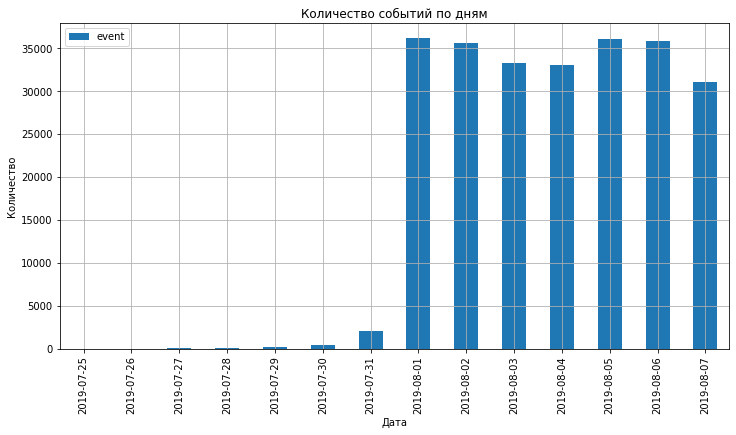

In [19]:
# график количества событий по дням
events_per_day = (app
                  .pivot_table(index='data', values='event', aggfunc='count')
                  .plot(y='event', kind='bar', grid=True, figsize=(12, 6))
                 )
plt.title("Количество событий по дням") 
plt.xlabel("Дата")
plt.ylabel("Количество") 
plt.show()

**Начиная с 1 августа 2019 года количество событий резко возрастает. С этого периода и будем далее изучать данные**

In [20]:
# отсекаем данные меньше 1 августа
app_new = app.query('time >= "2019-08-01 00:00:00"')

In [21]:
# количество событий в новом логе
(app_new['id'].count()/app['id'].count()).round(2)

0.99

In [22]:
#количество уникальных пользователей в новом логе
all_id_new = app_new['id'].nunique()
all_id_new

7534

После отбора событий после 1 августа у нас осталось 99% данных

Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [23]:
exp_count = app_new.groupby('exp_id')['id'].nunique().sort_values(ascending=False).reset_index()
exp_count.columns = ['exp_group', 'count']
exp_count

,exp_group,count
0,248,2537
1,247,2513
2,246,2484


## Изучение воронки событий

В ходе изечения воронки событий ответим на вопросы:

* На каком шаге теряете больше всего пользователей
* Какая доля пользователей доходит от первого события до оплаты

In [24]:
# события в логах
events = app_new.groupby('event')['id'].nunique().sort_values(ascending=False).reset_index()
events.columns = ['event_name', 'count']
events

,event_name,count
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [25]:
#функция для графиков
def graph_events(df, values, index):
    df = df
    
    plt.figure(figsize=(12,6))
    plt.bar(df[index], df[values])
    for i, val in enumerate(df[values].values):
        (
        plt.text(i, val, val, horizontalalignment='center', verticalalignment='bottom', 
                 fontdict={'fontweight':500, 'size':12})
        )    
    plt.title('Количество ' + index) 
    plt.xlabel(index)
    plt.ylabel("Коичество пользователей") 
    plt.show()

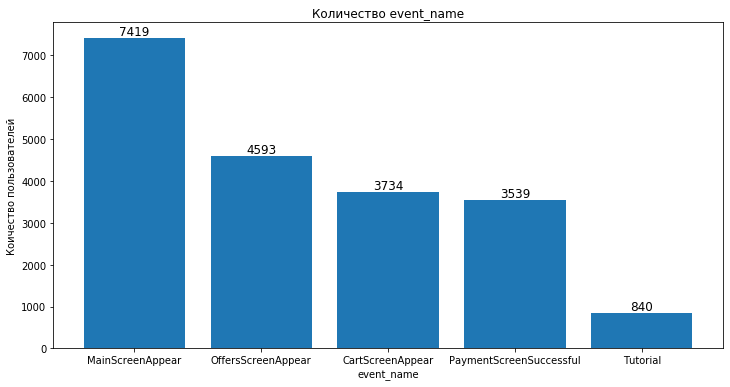

In [26]:
graph_events(events, 'count', 'event_name')

Чтобы посчитать долю пользователей, которые хоть раз совершали событие, разделим количество пользователей на каждом шаге на полное кодичество уникальных пользователей в app_new (all_id_new)

In [27]:
#процент пользователей от общего числа
events['persent_of_total'] = round(events['count'] / all_id_new, 2)
events

,event_name,count,persent_of_total
0,MainScreenAppear,7419,0.98
1,OffersScreenAppear,4593,0.61
2,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


Здесь мы можем сказать, что 98% всех пользователей просматривают начальный экран, 61% доходит до товара, 50% от общего числа переходят в корзину и 47% успешно оплачивают. 
Стоит отметить, что 11% от всех пользователей используют руководство пользователя.

Посмотрим как выглядит воронка событий для каждой из групп отдельно. 

In [28]:
#список уникальных значений экспериментов
app_new['exp_id'].unique()

array([246, 247, 248])

246 группа


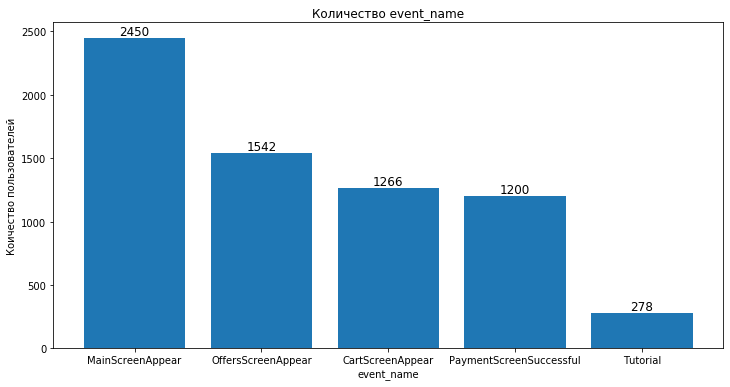

247 группа


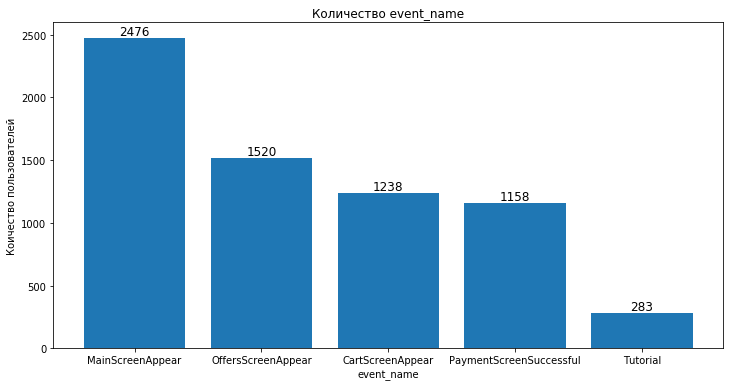

248 группа


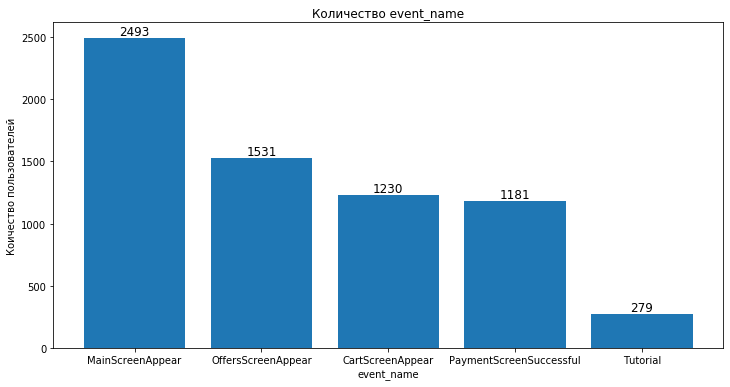

In [29]:
for i in app_new['exp_id'].unique():
    events_i = app_new.query('exp_id == @i').groupby('event')['id'].nunique().sort_values(ascending=False).reset_index()
    events_i.columns = ['event_name', 'count']
    print(i, 'группа')
    graph_events(events_i, 'count', 'event_name')


Все события происходят в следующем порядке:  

1) появление главного экрана (MainScreenAppear)  
2) появление экрана предложения/товара (OffersScreenAppear)  
3) появление экрана корзины (CartScreenAppear)  
4) появление экрана успешной оплаты (PaymentScreenSuccessful)  
5) появление руководства пользователя (Tutoria)

На мой взгляд, рассмотрение этапа загрузки руководства не является приоритеным в данном исследовании. Отдельно можно посмотреть потом в какой момент времени обращаются к руководству, таких пользователей 11%.
Сотредоточимся на цепочке событий: Гланый экран - Товар - Корзина - Успешная оплата.

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки от числа пользователей на предыдущем. 

In [30]:
# количество пользователей на каждом шаге воронки
events['persent_of_previous'] = 1 + round(events['count'].pct_change(), 2)


In [31]:
events

,event_name,count,persent_of_total,persent_of_previous
0,MainScreenAppear,7419,0.98,NaN
1,OffersScreenAppear,4593,0.61,0.62
2,CartScreenAppear,3734,0.50,0.81
3,PaymentScreenSuccessful,3539,0.47,0.95
4,Tutorial,840,0.11,0.24


При рассмотрении конверсии от этапа к этапу можно сказать, что все теже 98%  пользователей доходят до главного экрана, 62% от них переходят к товара, далее 81% от этого количества пользователей идет в корзину и 95% далее успешно оплачивают товар. 

**Вывод**

По проведенному анализу воронки продаж можно сказать, что 47% пользователей от общего числа доходят до этапа успешной оплаты. 
Стоит обратить внимание, что при переходе от загрузки главного экрана до этапа товара теряется 38% пользователей

##  Результаты эксперимента

246 и 247 — контрольные группы, а 248 — экспериментальная. Посмотрим количество пользователей в каждой группе еще раз.

In [32]:
exp_count

,exp_group,count
0,248,2537
1,247,2513
2,246,2484


In [33]:
# посчитаем уникальных пользователей в каждом сообытии по всем группам
events_246 = app_new.query('exp_id == 246').groupby('event')['id'].nunique().sort_values(ascending=False).reset_index()
events_246.columns = ['event_name', '246']

events_247 = app_new.query('exp_id == 247').groupby('event')['id'].nunique().sort_values(ascending=False).reset_index()
events_247.columns = ['event_name', '247']

events_248 = app_new.query('exp_id == 248').groupby('event')['id'].nunique().sort_values(ascending=False).reset_index()
events_248.columns = ['event_name', '248']

In [34]:
# сгруппируем все данные в одну таблицу
events_by_group = events_246.merge(events_247, on = 'event_name')
events_by_group = events_by_group.merge(events_248, on = 'event_name')

In [35]:
exp_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
exp_group    3 non-null int64
count        3 non-null int64
dtypes: int64(2)
memory usage: 176.0 bytes


In [36]:
# добавляем общее количество в группах
events_by_group.loc[5] = ['total', exp_count.loc[2,'count'], 
                          exp_count.loc[1,'count'], 
                         exp_count.loc[0,'count']]

In [37]:
exp_count.loc[2,'count']

2484

In [38]:
events_by_group

,event_name,246,247,248
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279
5,total,2484,2513,2537


Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов, проверим находят ли статистические критерии разницу между выборками 246 и 247.
Будем делать проверку гипотезы о равенстве долей (отношения числа пользователей из текущего события, делить на количество пользователей из прошлого ) Z-тестом.

Уровень статистической значимости во всех проверках устанавливаем 5%

In [39]:
def z_test_for_app(event, group1, group2):
    alpha = .05 # критический уровень статистической значимости
    successes = np.array([events_by_group[events_by_group['event_name'] == event][group1], 
              events_by_group[events_by_group['event_name'] == event][group2]])   
    trials = np.array([events_by_group[events_by_group['event_name'] == 'total'][group1], 
              events_by_group[events_by_group['event_name'] == 'total'][group2]])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)
    print('Событие', event)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между конверсиями групп', group1, 'и', group2, ' есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии', group1, 'и', group2, 'групп разными'
        ) 
    print('')


In [40]:
events_in_app = app_new['event'].unique()
events_in_app

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

In [41]:
def cycle_z_test(group1,group2):
    for element in events_in_app:
        z_test_for_app(element, group1, group2)
    

### Выборки №246 и №247

Сформулируем гипотезы:

Проверка №1


Нулевая гипотеза (Н0) - конверсия по событию **MainScreenAppear** группы 246 равна конверсии группы 247 (различие конверсий не является статистически значимым).   
Альтернативная гипотеза (Н1) - конверсия по событию**MainScreenAppear** группы 246 не равна конверсии группы 247 (разница статистически значима).

Проверка №2


Нулевая гипотеза (Н0) - конверсия по событию **OffersScreenAppear** группы 246 равна конверсии группы 247 (различие конверсий не является статистически значимым).   
Альтернативная гипотеза (Н1) - конверсия по событию**OffersScreenAppear** группы 246 не равна конверсии группы 247 (разница статистически значима).

Проверка №3

Нулевая гипотеза (Н0) - конверсия по событию **CartScreenAppear** группы 246 равна конверсии группы 247 (различие конверсий не является статистически значимым).   
Альтернативная гипотеза (Н1) - конверсия по событию **CartScreenAppear** группы 246 не равна конверсии группы 247 (разница статистически значима).

Проверка №4

Нулевая гипотеза (Н0) - конверсия по событию **PaymentScreenSuccessful** группы 246 равна конверсии группы 247 (различие конверсий не является статистически значимым).   
Альтернативная гипотеза (Н1) - конверсия по событию **PaymentScreenSuccessful** группы 246 не равна конверсии группы 247 (разница статистически значима).

In [42]:
cycle_z_test('246','247')

p-значение:  [0.93769962]
Событие Tutorial
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии 246 и 247 групп разными

p-значение:  [0.75705972]
Событие MainScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии 246 и 247 групп разными

p-значение:  [0.24809546]
Событие OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии 246 и 247 групп разными

p-значение:  [0.22883372]
Событие CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии 246 и 247 групп разными

p-значение:  [0.11456679]
Событие PaymentScreenSuccessful
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии 246 и 247 групп разными



**Вывод**

Для каждого этапа для наших контрольных групп 246 и 247 нулевая гипотеза, что конверсии равны, не была отвергнута. Таким образом у нас нет оснований считать конверсии  этих групп разными. 
Далее мы можем использовать данные по обеим группам А/А теста для сравнения с экспериментальной 248

В дальнейшем для расчетов нам потребуется сравнить результаты с объединенной группой. Сразу добавим столбец со значениями 246+247 групп.

In [43]:
events_by_group['246+247'] = events_by_group['246'] + events_by_group['247'] 
events_by_group

,event_name,246,247,248,246+247
0,MainScreenAppear,2450,2476,2493,4926
1,OffersScreenAppear,1542,1520,1531,3062
2,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358
4,Tutorial,278,283,279,561
5,total,2484,2513,2537,4997


Сравнивам  результаты с каждой из контрольных групп в отдельности по каждому событию.Далее сравним результаты с объединённой контрольной группой. 

### Выборки №246 и №248

Последовательно проверям гипотезы:

Нулевая гипотеза (Н0) - конверсия по событию **Tutorial / MainScreenAppear / OffersScreenAppear** / **CartScreenAppear** / **PaymentScreenSuccessful**  группы 246 равна конверсии группы 248 (различие конверсий не является статистически значимым).   
Альтернативная гипотеза (Н1) - конверсия по событию **Tutorial / MainScreenAppear / OffersScreenAppear** / **CartScreenAppear** / **PaymentScreenSuccessful** группы 246 не равна конверсии группы 248 (разница статистически значима).

In [44]:
cycle_z_test('246','248')

p-значение:  [0.8264294]
Событие Tutorial
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии 246 и 248 групп разными

p-значение:  [0.29497219]
Событие MainScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии 246 и 248 групп разными

p-значение:  [0.20836205]
Событие OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии 246 и 248 групп разными

p-значение:  [0.07842923]
Событие CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии 246 и 248 групп разными

p-значение:  [0.21225533]
Событие PaymentScreenSuccessful
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии 246 и 248 групп разными



**Вывод**

Для каждого этапа для контрольной группы 246 и экспериментальной 248 нулевая гипотеза, что конверсии равны, не была отвергнута. Таким образом у нас нет оснований считать конверсии  этих групп разными. 

### Выборки №247 и №248

Последовательно проверям гипотезы:

Нулевая гипотеза (Н0) - конверсия по событию **Tutorial / MainScreenAppear / OffersScreenAppear** / **CartScreenAppear** / **PaymentScreenSuccessful**  группы 247 равна конверсии группы 248 (различие конверсий не является статистически значимым).   
Альтернативная гипотеза (Н1) - конверсия по событию**Tutorial / MainScreenAppear / OffersScreenAppear** / **CartScreenAppear** / **PaymentScreenSuccessful** группы 247 не равна конверсии группы 248 (разница статистически значима).

In [45]:
cycle_z_test('247','248')

p-значение:  [0.76532392]
Событие Tutorial
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии 247 и 248 групп разными

p-значение:  [0.45870536]
Событие MainScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии 247 и 248 групп разными

p-значение:  [0.91978178]
Событие OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии 247 и 248 групп разными

p-значение:  [0.57861979]
Событие CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии 247 и 248 групп разными

p-значение:  [0.73734151]
Событие PaymentScreenSuccessful
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии 247 и 248 групп разными



**Вывод**

Для каждого этапа для контрольной группы 247 и экспериментальной 248 нулевая гипотеза, что конверсии равны, не была отвергнута. Таким образом у нас нет оснований считать конверсии  этих групп разными. 

### Выборки №246+247 и №248

Последовательно проверям гипотезы:

Нулевая гипотеза (Н0) - конверсия по событию **Tutorial / MainScreenAppear / OffersScreenAppear** / **CartScreenAppear** / **PaymentScreenSuccessful**  группы 246+247 равна конверсии группы 248 (различие конверсий не является статистически значимым).   
Альтернативная гипотеза (Н1) - конверсия по событию**Tutorial / MainScreenAppear / OffersScreenAppear** / **CartScreenAppear** / **PaymentScreenSuccessful** группы 246+247 не равна конверсии группы 248 (разница статистически значима).

In [46]:
cycle_z_test('246+247','248')

p-значение:  [0.76486247]
Событие Tutorial
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии 246+247 и 248 групп разными

p-значение:  [0.29424527]
Событие MainScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии 246+247 и 248 групп разными

p-значение:  [0.4342555]
Событие OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии 246+247 и 248 групп разными

p-значение:  [0.18175875]
Событие CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии 246+247 и 248 групп разными

p-значение:  [0.60042943]
Событие PaymentScreenSuccessful
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии 246+247 и 248 групп разными



**Вывод**

Для каждого этапа для контрольной группы 246+247 и экспериментальной 248 нулевая гипотеза, что конверсии равны, не была отвергнута. Таким образом у нас нет оснований считать конверсии  этих групп разными. 

## Вывод

В нашем датасете 244 126 записи. Каждая запись в логе — это действие пользователя, или событие. Для дальнейшей работы с данными мы удалили дубликаты, пропусков обнаружено не было. Отдельно выделили дату совершения событий пользователей. 
Минимальная дата в наших данных – 25 июля 2019 г., максимальная – 7 августа 2019 г.
Далее мы построили график числа событий по дням и сделали вывод, что с 1 августа количество событий резко возрастает. С этого временного отрезка в дальнейшем и проводили наши исследования. После отбора событий после 1 августа у нас осталось 99% данных.

На этапе рассмотрения воронки событий мы обнаружили, что события происходят в следующем порядке:  

1) появление главного экрана (MainScreenAppear)  
2) появление экрана предложения/товара (OffersScreenAppear)  
3) появление экрана корзины (CartScreenAppear)  
4) появление экрана успешной оплаты (PaymentScreenSuccessful)  

Отдельно стоит сказать, что 11% от всех пользователей используют руководство пользователя. В дальнейшем, можно рассмотреть после каких этапов пользовалитли чаще обращаются к руководству.
В последующих расчетов мы исключили этот этап из рассмотрения. 


По воронке событий можно сделать вывод, что 98% всех пользователй просматривают начальный экран, 61% доходит до товара, 50% от общего числа переходят в корзину и 47% успешно оплачивают. 
При рассмотрении конверсии от этапа к этапу можно сказать, что все теже 98%  пользователей доходят до главного экрана, 62% от них переходят к товара, далее 81% от этого количества пользователей идет в корзину и 95% далее успешно оплачивают товар.

Важно отметить, что 47% пользователей от общего числа доходят до этапа успешной оплаты и что при переходе от загрузки главного экрана до этапа товара теряется 38% пользователей.

Далее мы перешли к тестам для проверки статистически значимых изменений по каждому выду событий для двух контрольных групп (и дополнительно по их суммам) и 248 – экспериментальной. Всего в общей сложности было сделано 20 тестов, по 5 для каждой пары.  
Уровень статистической значимости во всех проверках был установлен в  5%
В результате проверок для каждого этапа всех наших групп нулевая гипотеза, что конверсии равны, не была отвергнута. 
Таким образом, в результате проведения всех тестов мы можем сказать, что изменение шрифта не повлияло на поведение пользователей в большинстве этапов. 
